# GRUPO 3:

LAURA HERRERA

YUDDY LORENA GIRALDO

CARLOS VASQUEZ

In [ ]:
!pip install factor-analyzer

In [36]:
!pip install kneed

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# para PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer
# GMM
from sklearn import cluster
from sklearn.metrics import silhouette_score # indicador para consistencia de cluster
from kneed import KneeLocator # para identificar analiticamente el cambio de la pendiente
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture

Diccionario de datos

CUST_ID: Identificación del titular de la tarjeta de crédito

BALANCE: Saldo disponible para compras

BALANCE_FREQUENCY: Frecuencia de actualización del saldo (donde 1 = actualización frecuente y 0 = no se actualiza con frecuencia).

PURCHASES: Importe de las compras realizadas por el cliente

ONEOFF_PURCHASES: Importe máximo de la compra realizada a una couta

INSTALLMENTS_PURCHASES: Importe de las compras realizadas a plazos

CASH_ADVANCE: Avances de Efectivo realizados por el usuario

PURCHASES_FREQUENCY: Frecuencia con la que se realizan las compras (1 = compras frecuentes, 0 = compras poco frecuentes)

ONEOFF_PURCHASES_FREQUENCY: frecuencia con la que se realizan las compras a una couta (1 = compras frecuentes, 0 = compras poco frecuentes)

PURCHASES_INSTALLMENTS_FREQUENCY: Frecuencia con la que se realizan compras a plazos (1 = se realizan con frecuencia, 0 = no se realizan con frecuencia)

CASH_ADVANCE_FREQUENCY: Frecuencia con la que se realizan avances de efectivo

CASH_ADVANCE_TRX: Número de transacciones realizadas por "avances de efectivo"

PURCHASES_TRX: Número de transacciones de compra realizadas

CREDIT_LIMIT: Límite de la tarjeta de crédito del usuario

PAYMENTS: Importe de los pagos realizados por el usuario

MINIMUM_PAYMENTS: Importe mínimo de los pagos realizados por el usuario

PRC_FULL_PAYMENT: Porcentaje del pago total abonado por el usuario

TENURE: Tenencia del servicio de tarjeta de crédito para el usuario

In [38]:
# para que los resultados no salgan en notacion cientifica
np.set_printoptions(precision=4, suppress=True)

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
# cargar base de datos
df = pd.read_csv('/content/drive/MyDrive/credit_card_clients.csv')

In [41]:
# funcion para hacer un resumen de la información de la base de datos
from IPython.display import display, Markdown
pd.set_option('display.max_columns', None)

In [42]:
def check_df(dataframe, head=10):
    display(Markdown('**Dimensiones base general**'))
    display(dataframe.shape)

    display(Markdown('**Dimensiones sin duplicados**'))
    display(dataframe.drop_duplicates().shape )

    display(Markdown('**Tipos**'))
    display(dataframe.dtypes)

    display(Markdown('**Primeros Registros**'))
    display(dataframe.head(head))

    display(Markdown('**Nulos**'))
    display(dataframe.isnull().sum())

    display(Markdown('**Percentiles**'))
    display(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
check_df(df)

**Dimensiones base general**

(8950, 18)

**Dimensiones sin duplicados**

(8950, 18)

**Tipos**

CUST_ID                              object
BALANCE                             float64
BALANCE_FREQUENCY                   float64
PURCHASES                           float64
ONEOFF_PURCHASES                    float64
INSTALLMENTS_PURCHASES              float64
CASH_ADVANCE                        float64
PURCHASES_FREQUENCY                 float64
ONEOFF_PURCHASES_FREQUENCY          float64
PURCHASES_INSTALLMENTS_FREQUENCY    float64
CASH_ADVANCE_FREQUENCY              float64
CASH_ADVANCE_TRX                      int64
PURCHASES_TRX                         int64
CREDIT_LIMIT                        float64
PAYMENTS                            float64
MINIMUM_PAYMENTS                    float64
PRC_FULL_PAYMENT                    float64
TENURE                                int64
dtype: object

**Primeros Registros**

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.000000,12
6,C10007,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.000000,0.000000,0,64,13500.0,6354.314328,198.065894,1.000000,12
7,C10008,1823.652743,1.000000,436.20,0.00,436.20,0.000000,1.000000,0.000000,1.000000,0.000000,0,12,2300.0,679.065082,532.033990,0.000000,12
8,C10009,1014.926473,1.000000,861.49,661.49,200.00,0.000000,0.333333,0.083333,0.250000,0.000000,0,5,7000.0,688.278568,311.963409,0.000000,12
9,C10010,152.225975,0.545455,1281.60,1281.60,0.00,0.000000,0.166667,0.166667,0.000000,0.000000,0,3,11000.0,1164.770591,100.302262,0.000000,12


**Nulos**

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

**Percentiles**

,count,mean,std,min,0%,5%,50%,95%,99%,100%,max
BALANCE,8950.0,1564.474828,2081.531879,0.000000,0.000000,8.814518,873.385231,5909.111808,9338.804814,19043.13856,19043.13856
BALANCE_FREQUENCY,8950.0,0.877271,0.236904,0.000000,0.000000,0.272727,1.000000,1.000000,1.000000,1.00000,1.00000
PURCHASES,8950.0,1003.204834,2136.634782,0.000000,0.000000,0.000000,361.280000,3998.619500,8977.290000,49039.57000,49039.57000
ONEOFF_PURCHASES,8950.0,592.437371,1659.887917,0.000000,0.000000,0.000000,38.000000,2671.094000,6689.898200,40761.25000,40761.25000
INSTALLMENTS_PURCHASES,8950.0,411.067645,904.338115,0.000000,0.000000,0.000000,89.000000,1750.087500,3886.240500,22500.00000,22500.00000
CASH_ADVANCE,8950.0,978.871112,2097.163877,0.000000,0.000000,0.000000,0.000000,4647.169122,9588.163357,47137.21176,47137.21176
PURCHASES_FREQUENCY,8950.0,0.490351,0.401371,0.000000,0.000000,0.000000,0.500000,1.000000,1.000000,1.00000,1.00000
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.202458,0.298336,0.000000,0.000000,0.000000,0.083333,1.000000,1.000000,1.00000,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.364437,0.397448,0.000000,0.000000,0.000000,0.166667,1.000000,1.000000,1.00000,1.00000
CASH_ADVANCE_FREQUENCY,8950.0,0.135144,0.200121,0.000000,0.000000,0.000000,0.000000,0.583333,0.833333,1.50000,1.50000


In [43]:
# porcentaje de nulos
(313/8950)*100

3.4972067039106145

Se identifican datos nulos en la variable *MINIMUM_PAYMENTS*. Se decide eliminarlos ya que representa un porcentaje muy bajo del total de los datos y no se hace un tratamiento porque no tenemos suficiente conocimiento respecto a la base utilizada

# Reducción de dimensiones

In [44]:
# Eliminar variable CUST_ID
df2 = df.drop('CUST_ID', axis = 1)
# Eliminar datos nulos
df2 = df2.dropna()

Se decide eliminar la variable *CUST_ID* porque es una variable categorica y pasarla a dummies no es significativo para el modelo, ya que esta variable es un identificador, es decir, un registro es único por cada fila.

In [45]:
# Escalar los datos
feat_sc = StandardScaler().fit_transform(df2)

In [46]:
# Afinamiento de parametros
pca = PCA(n_components = 8)
# ajuste de datos
pca.fit(feat_sc)
# Lambdas, vectores propios, o pesos observados sobre las latentes
pca.components_

array([[ 0.092 ,  0.1098,  0.4122,  0.3468,  0.3371, -0.0306,  0.3237,
         0.2948,  0.2772, -0.0991, -0.057 ,  0.3911,  0.2101,  0.2637,
         0.0593,  0.1306,  0.0779],
       [ 0.406 ,  0.1277,  0.0495,  0.0699, -0.0115,  0.4372, -0.1866,
        -0.0147, -0.1736,  0.43  ,  0.4164, -0.0119,  0.2438,  0.2642,
         0.1704, -0.1957, -0.0046],
       [-0.1742, -0.4589,  0.2426,  0.3686, -0.1038, -0.0017, -0.3557,
         0.1047, -0.4499, -0.0876, -0.0871, -0.0798,  0.0952,  0.2879,
        -0.2487,  0.1842, -0.0657],
       [ 0.2594,  0.1593,  0.064 ,  0.1231, -0.075 , -0.2656, -0.2217,
         0.0555, -0.2653, -0.2666, -0.3326, -0.0241,  0.1227, -0.0975,
         0.3522, -0.4182,  0.4284],
       [ 0.0757, -0.4509, -0.0104, -0.197 ,  0.3375,  0.0994, -0.0885,
        -0.5216,  0.1754, -0.1599, -0.0897, -0.0525,  0.132 ,  0.1892,
         0.4168,  0.2011,  0.1178],
       [ 0.0358, -0.0147,  0.196 ,  0.173 ,  0.1454, -0.1325, -0.0857,
        -0.0968, -0.0475,  0.0315, -0.0

Inicialmente, para la reducción de dimensiones consideramos el valor máximo de variables latentes posibles, en este caso 17. Sin embargo, identificamos que las dos primeras variables latentes explicaban aproximadamente el 45% y el resto menos del 10%. Por lo tanto, decidimos reducir el número de componentes a más o menos la mitad, es decir 8.

1. Cuáles son las variables observadas más importantes en las dos variables latentes más importantes.


In [47]:
import numpy as np

# Supongamos que deseas las dos primeras componentes principales
primer_componente = pca.components_[0]
segundo_componente = pca.components_[1]

# Los coeficientes de las variables originales en el primer componente
coeficientes_primer_componente = primer_componente
# Los coeficientes de las variables originales en el segundo componente
coeficientes_segundo_componente = segundo_componente

# Obtén los índices de las variables originales más importantes en cada componente
indices_importantes_en_primer_componente = np.abs(coeficientes_primer_componente).argsort()[::-1]
indices_importantes_en_segundo_componente = np.abs(coeficientes_segundo_componente).argsort()[::-1]

# Lista de nombres de las variables originales
nombres_variables = df2.columns

# Ahora puedes identificar las variables más importantes en cada componente
variables_importantes_en_primer_componente = [nombres_variables[i] for i in indices_importantes_en_primer_componente]
variables_importantes_en_segundo_componente = [nombres_variables[i] for i in indices_importantes_en_segundo_componente]

print("Variables importantes en el primer componente:")
print(variables_importantes_en_primer_componente)

print("Variables importantes en el segundo componente:")
print(variables_importantes_en_segundo_componente)

Variables importantes en el primer componente:
['PURCHASES', 'PURCHASES_TRX', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'PAYMENTS', 'CREDIT_LIMIT', 'PRC_FULL_PAYMENT', 'BALANCE_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'BALANCE', 'TENURE', 'MINIMUM_PAYMENTS', 'CASH_ADVANCE_TRX', 'CASH_ADVANCE']
Variables importantes en el segundo componente:
['CASH_ADVANCE', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'BALANCE', 'PAYMENTS', 'CREDIT_LIMIT', 'PRC_FULL_PAYMENT', 'PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'MINIMUM_PAYMENTS', 'BALANCE_FREQUENCY', 'ONEOFF_PURCHASES', 'PURCHASES', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_TRX', 'INSTALLMENTS_PURCHASES', 'TENURE']


En la primera variable latente las primeras 5 variables mas importes son: 'PURCHASES', 'PURCHASES_TRX', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'PURCHASES_FREQUENCY'. Y en la segunda variable latente son: 'CASH_ADVANCE', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'BALANCE', 'PAYMENTS'

In [48]:
# valores propios = cantidad de varianza explicada
pca.explained_variance_
# porcentaje de varianza explicada. Con esta se hace la regla del codo
ve = pca.explained_variance_ratio_
ve

array([0.2723, 0.2037, 0.0892, 0.0757, 0.0628, 0.0571, 0.0492, 0.0421])

In [49]:
# suma de porcentaje de variacion explicada con las 8 variables latentes
ve.sum()

0.8521375332973691

2. Qué porcentaje de variación va a explicar y cuántas variables latentes va a utilizar para representar los datos.

Vamos a usar las 8 componetes latentes, ya que estas explican el 85% de la variabilidad de los datos

<ipython-input-50-1b85ad16f1f8>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=np.arange(1,9), y=np.cumsum(ve), palette='vidiris')


<Axes: >

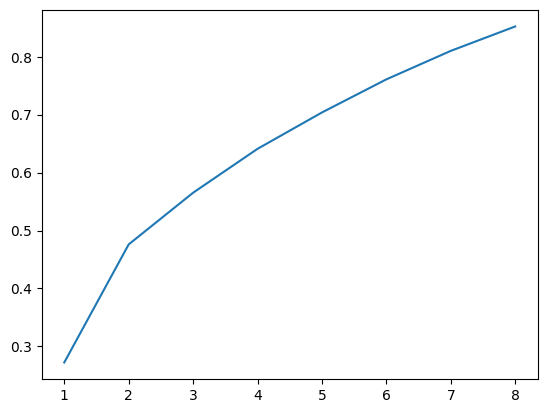

In [50]:
## Regla del codo
sns.lineplot(x=np.arange(1,9), y=np.cumsum(ve), palette='vidiris')

In [51]:
# variables latentes
l = pca.transform(feat_sc)
# latentes seleccionadas
l_sel = pd.DataFrame(l)
l_sel

,0,1,2,3,4,5,6,7
0,-1.696395,-1.122584,0.491562,0.719521,0.079830,0.118234,0.808993,-0.093970
1,-1.215681,2.435638,0.694658,-0.098843,0.803019,-0.917777,-0.322969,-0.045119
2,0.935853,-0.385202,-0.025953,1.293844,-1.987285,-0.682139,-1.624721,0.073401
3,-1.614638,-0.724586,0.272358,1.086116,-0.427814,0.082982,0.687001,0.063548
4,0.223701,-0.783610,-1.184434,0.721353,0.801243,0.525879,0.788893,-0.089942
...,...,...,...,...,...,...,...,...
8631,-2.221637,-1.328411,1.643826,-1.421354,-0.175573,3.518499,-1.313848,-0.870622
8632,-0.362326,-2.032249,-0.875053,-2.800940,-0.313566,2.808854,-1.549426,-0.210773
8633,-0.930026,-1.841236,-0.350037,-2.351591,-0.219492,3.090269,-1.421757,-0.630976
8634,-2.356010,-0.718730,1.048522,-1.776467,-0.552690,3.333452,-0.996810,-0.263088


## Aprendizaje no supervisado

<Axes: >

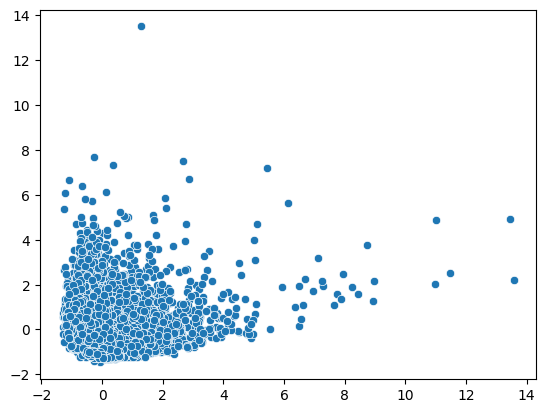

In [52]:
# Escalado de variables
x_s = StandardScaler().fit_transform(l_sel)
# Grafico de dos variables sin clusteres
sns.scatterplot(x= x_s[:,0], y=x_s[:,1])

In [53]:
# modelo
gmm = GaussianMixture(n_components=5, covariance_type='full', n_init=5)
# ajustar
gmm.fit(x_s)
gmm.aic(x_s) ## indicador para comparar con otro modelo. Por si solo no se interpreta
gmm.bic(x_s) ## indicador para comparar con otro modelo. Por si solo no se interpreta
gmm.score(x_s) ## indicador de verosimilitud
gmm.predict_proba(x_s)[0] # Fila cero, probabilidad de pertenecia a cada uno de los 5 cluster

array([0.    , 0.    , 0.0022, 0.    , 0.9978])

In [54]:
# grilla de hiperparametros
paramg = {
    'n_components':[3,4,5,6,7,8],
    'covariance_type':['full', 'tied', 'spherical', 'diag']
}

# Funcion para optimizar hiperparametros
gs = GridSearchCV(gmm, param_grid=paramg)
# ajustar modelo
gs.fit(x_s)

GridSearchCV(estimator=GaussianMixture(n_components=5, n_init=5),
             param_grid={'covariance_type': ['full', 'tied', 'spherical',
                                             'diag'],
                         'n_components': [3, 4, 5, 6, 7, 8]})

In [55]:
# Resultados
df_resultados = pd.DataFrame(gs.cv_results_)
df_resultados[['params', 'mean_test_score']].sort_values('mean_test_score', ascending = False)

,params,mean_test_score
5,"{'covariance_type': 'full', 'n_components': 8}",-3.979493
4,"{'covariance_type': 'full', 'n_components': 7}",-4.251355
3,"{'covariance_type': 'full', 'n_components': 6}",-4.585539
2,"{'covariance_type': 'full', 'n_components': 5}",-5.038992
1,"{'covariance_type': 'full', 'n_components': 4}",-5.832624
0,"{'covariance_type': 'full', 'n_components': 3}",-7.253348
23,"{'covariance_type': 'diag', 'n_components': 8}",-8.202401
22,"{'covariance_type': 'diag', 'n_components': 7}",-8.501807
17,"{'covariance_type': 'spherical', 'n_components...",-8.557687
21,"{'covariance_type': 'diag', 'n_components': 6}",-8.700125


<Axes: >

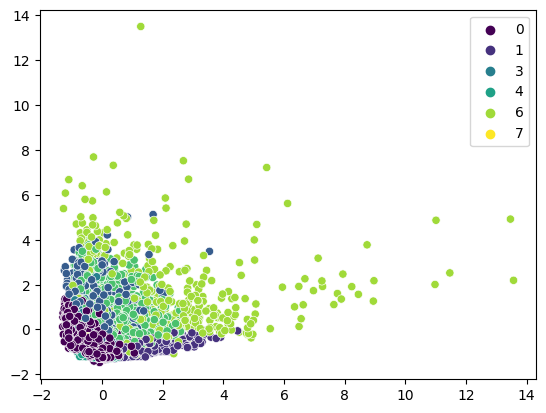

In [56]:
# Mejor resultado
gmm_gan=gs.best_estimator_
# guardar los cluster en una variable
cluster = gmm_gan.fit_predict(x_s)
# graficar hue=categorias o clusteres
sns.scatterplot(x=x_s[:,0], y=x_s[:,1], hue=cluster, palette = 'viridis')

In [57]:
# crear una copia de la base original
df3 = df2.copy()
# agregar la variable con los clusteres
df3['cluster'] = cluster
df3

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,4
1,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,2
2,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,5
4,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,3
5,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.000000,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8943,5.871712,0.500000,20.90,20.90,0.00,0.000000,0.166667,0.166667,0.000000,0.000000,0,1,500.0,58.644883,43.473717,0.000000,6,0
8945,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6,0
8947,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6,0
8948,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6,0


In [58]:
# Calcular estadísticas descriptivas para cada cluster
cluster_stats = df3.groupby('cluster').describe()
# Filtrar estadísticas: media (mean), mínimo (min) y máximo (max)
cluster_stats_filtered = cluster_stats.loc[:, (slice(None), ['mean', 'std', 'min', 'max'])]
cluster_stats_filtered

BALANCE                                      BALANCE_FREQUENCY  \
                mean          std       min           max              mean   
cluster                                                                       
0         598.233720   642.012980  0.000000   3857.278468          0.751407   
1         338.118321   261.867576  9.503968   1272.927288          0.994402   
2        3272.111107  2169.173757  0.488050  15258.225900          0.938574   
3        2340.818493  2005.008290  5.006737  14224.115410          0.999929   
4          48.411047    46.981841  0.000000    299.179091          0.674214   
5        3011.473547  2384.728774  1.198223  15532.339720          0.996643   
6        3260.604604  3540.987424  1.632453  19043.138560          0.877767   
7        1230.384911   817.520798  2.641101   4496.709257          1.000000   

                                    PURCHASES                                \
              std       min  max         mean          std    min       max   
cluster                                                                       
0        0.244053  0.000000  1.0   412.941924   601.341610   0.00   4924.41   
1        0.021867  0.909091  1.0  2213.350862  1693.627412  96.20  10903.22   
2        0.102299  0.454545  1.0   615.872464  1106.138529   0.00   8533.54   
3        0.002532  0.909091  1.0    22.660566    59.045093   0.00    439.38   
4        0.284632  0.000000  1.0   435.420817   358.729435   0.01   2600.00   
5        0.019775  0.727273  1.0  1354.394924  1310.091546   0.00   6697.57   
6        0.207604  0.090909  1.0  4978.070166  6288.357638   0.00  49039.57   
7        0.000000  1.000000  1.0   538.859074   416.647545   0.00   2108.56   

        ONEOFF_PURCHASES                             INSTALLMENTS_PURCHASES  \
                    mean          std  min       max                   mean   
cluster                                                                       
0             255.688241   518.548564  0.0   4924.41             157.482273   
1            1301.604163  1463.243125  0.0   8945.67             912.485616   
2             328.796327   761.418852  0.0   6520.00             287.076137   
3              22.660566    59.045093  0.0    439.38               0.000000   
4             130.579947   273.072922  0.0   2600.00             305.426417   
5             819.965651  1029.281567  0.0   5910.04             534.712321   
6            3199.668840  5236.010788  0.0  40761.25            1778.441842   
7             292.882584   395.150003  0.0   2094.38             246.428052   

                                    CASH_ADVANCE                    \
                 std  min       max         mean          std  min   
cluster                                                              
0         286.114620  0.0   2068.15   815.311462  1121.772725  0.0   
1         923.626531  0.0   6229.41     0.000000     0.000000  0.0   
2         682.556816  0.0   7739.48  3019.300849  3130.272492  0.0   
3           0.000000  0.0      0.00  1204.639645  1332.707419  0.0   
4         311.276488  0.0   1879.13     0.000000     0.000000  0.0   
5         673.805601  0.0   3816.00  1613.782220  2105.694029  0.0   
6        2601.572185  0.0  22500.00  3020.735714  5309.012481  0.0   
7         267.818425  0.0   1680.00   123.201154   310.502194  0.0   

                      PURCHASES_FREQUENCY                                \
                  max                mean       std       min       max   
cluster                                                                   
0         7313.203925            0.354274  0.378980  0.000000  1.000000   
1            0.000000            0.939655  0.112810  0.416667  1.000000   
2        18857.058470            0.344382  0.379658  0.000000  1.000000   
3         8362.154254            0.018554  0.038930  0.000000  0.166667   
4            0.000000            0.568054  0.327549  0.083333  1.000000   
5        11657.312440           

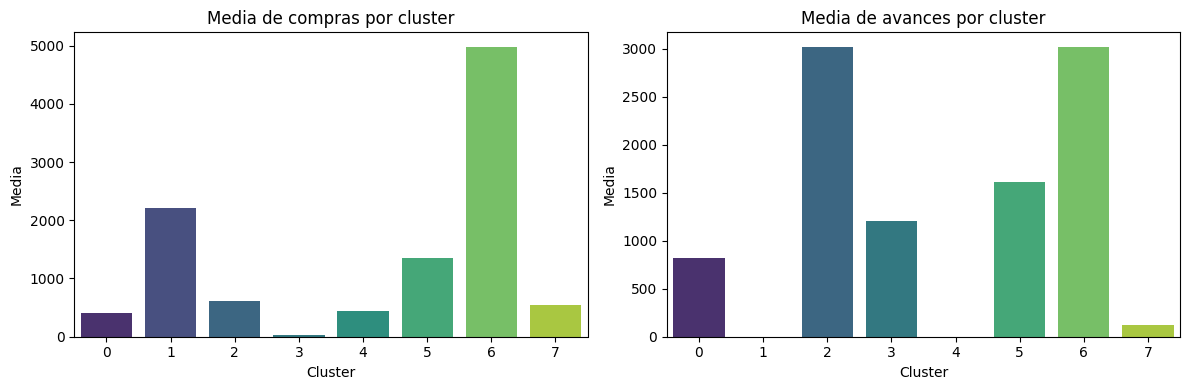

In [59]:
# Filtrar estadísticas para la media
mean_stats = cluster_stats_filtered.xs('mean', axis=1, level=1)

# Crear subgráficos para ambas visualizaciones
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de barras para la media de compras por cluster
sns.barplot(data=mean_stats.reset_index(), x='cluster', y='PURCHASES', palette='viridis', ax=axes[0])
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Media')
axes[0].set_title('Media de compras por cluster')

# Gráfico de barras para la media de avances por cluster
sns.barplot(data=mean_stats.reset_index(), x='cluster', y='CASH_ADVANCE', palette='viridis', ax=axes[1])
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Media')
axes[1].set_title('Media de avances por cluster')

# Mostrar los subgráficos
plt.tight_layout()
plt.show()

3. Diga cuáles son las principales diferencias entre los segmentos encontrados.

Se analizan las medias de las variables con mayor peso en las variables latentes una esta relacionada con la cantidad de compras y la otra con la cantidad de avances realizados:

Cluster 0: En este segmento las personas realizan pocas compras con las tarjetas de credito, pero usan mas sus tarjetas para hacer avances.

Cluster 1: En este cluster las personas realizan compras pero no avances.

Cluster 2: Las personas segmentadas en el cluster 2 tienen una media cercana a las 3000 unidades y una media de compras superior a 2000 unidades, en terminos generales hacen un uso significativo de su tarjeta de credito para ambas actividades.

Cluster 3: En este segmento de clientes el uso de las tarjetas para compras es casi nulo, pero para avances el promedio es superior a 1000.

Cluster 4: En este grupo de personas se evidencia un uso muy bajo de las tarjetas para ambas actividades.

Cluster 5: En este cluster se realizan pocas compras, sin embargo su media para el caso de los avances es buena.

Cluster 6: Este es uno de los cluster mas interesantes para el analisis que se esta haciendo ya que tienen las medias mas altas en ambas actividades financieras con sus tarjetas de creditos.

Cluster 7: El custer 7 tiene medias muy bajas en ambos actividades analizadas.

4. Con base en las características identificadas en los segmentos proponga alguna estrategia que se pueda implementar en cada uno.

A partir de la segmentación realizada proponemos las siguientes estrategias para los de usuarios de tarjetas de crédito:

1. **Cluster 0 - Pocas Compras, Más Avances:**
   - Estrategia: Ofrecer programas de fidelización que recompensen el uso de la tarjeta para compras con beneficios o descuentos. También, proporcionar asesoramiento financiero para enseñar a los usuarios a utilizar sus tarjetas de crédito de manera más efectiva.

2. **Cluster 1 - Compras Sin Avances:**
   - Estrategia: Introducir programas de recompensas que se centren en las compras, ofreciendo puntos o descuentos para incentivar las compras regulares con la tarjeta de crédito.

3. **Cluster 2 - Uso Significativo para Ambas Actividades:**
   - Estrategia: Ofrecer límites de crédito más altos y opciones de financiamiento flexibles para aprovechar al máximo el uso activo de la tarjeta tanto para compras como para avances.

4. **Cluster 3 - Casi Sin Compras, Avances:**
   - Estrategia: Destacar los beneficios y conveniencia de usar la tarjeta para avances en efectivo, quizás con tasas de interés bajas o incentivos para atraer más avances.

5. **Cluster 4 - Uso Muy Bajo para Ambas Actividades:**
   - Estrategia: Lanzar programas de educación financiera y recompensas para fomentar el uso responsable de las tarjetas de crédito, incentivando a los usuarios a aprovechar los beneficios de sus tarjetas.

6. **Cluster 5 - Pocas Compras, Buen Uso de Avances:**
   - Estrategia: Promover los avances como una opción rápida y conveniente, quizás con tasas de interés competitivas, y ofrecer incentivos para aumentar las compras.

7. **Cluster 6 - Uso Alto para Ambas Actividades:**
   - Estrategia: Ofrecer programas de recompensas y beneficios exclusivos, como seguros, límites de crédito más altos y servicios personalizados para mantener la lealtad de estos clientes valiosos.

8. **Cluster 7 - Medias Muy Bajas en Ambas Actividades:**
   - Estrategia: Implementar campañas de educación financiera para ayudar a estos usuarios a comprender los beneficios y el uso responsable de las tarjetas de crédito, así como para atraerlos a utilizar sus tarjetas de manera más activa.